In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

In [0]:
train_data = pd.read_csv("My Drive/Colab Notebooks/quasar_train.csv", header=-1).to_numpy()
test_data = pd.read_csv("My Drive/Colab Notebooks/quasar_test.csv", header=-1).to_numpy()

In [0]:
def smooth_lwr(data):
  smooth_data = []
  x_localreg = np.append(np.ones((data[0,:].shape[0], 1)), data[0,:].reshape(data[0,:].shape[0], 1), axis=1)

  tau = 5

  y = data[1:, :]

  def W(x, tau):
    w = []
    for i in range(x_localreg.shape[0]):
      w.append(math.exp(-((x_localreg[i,:]-x).T@(x_localreg[i,:]-x))/(2*tau**2)))
    return np.diag(np.array(w))

  for i in range(y.shape[0]):
    theta_lwr = []
    for j in range(x_localreg.shape[0]):
      w = W(x_localreg[j,:], tau)
      theta_lwr.append(np.linalg.inv(x_localreg.T@w@x_localreg)@x_localreg.T@w@y[i])

    pred = []
    for k in range (x_localreg.shape[0]):
      pred.append(np.asscalar(x_localreg[k,:]@theta_lwr[k]))

    smooth_data.append(pred)

  return np.array(smooth_data)

smooth_train_data = smooth_lwr(train_data)
smooth_test_data = smooth_lwr(test_data)

In [5]:
f_train = smooth_train_data

# Number of examples
m1 = 200

# Ker
def ker(t):
  return max(1-t, 0)

# Number of neighbors
k = 3

# Return index of h and indexes of three nearest neighbors for f_right
def h_and_nn(f_right_all, f_right):
  # Only sum the wavelengths on the right [1300, 1599]
  d_all = np.sum(np.square(f_right_all[:, 150:] - f_right[150:]), axis=1)

  # Sort, ascending, return indexes
  idx = np.argsort(d_all)

  # Final results
  h = d_all[idx[-1]]
  d_idx = idx[:k]
  d_val = [d_all[i] for i in idx[:k]]
  
  # Return h, indexes of three smallest d, three smallest d
  return h, d_idx, d_val

# Functional regression, return f_left prediction for each example
def fr(f):
  pred_f_left = []
  for j in range(f.shape[0]):
    # Predicted f_left
    pred_f_left_j = np.array([])

    # Get indexes of h and 3 nearest neighbors
    h, d_idx, d_val = h_and_nn(f_train, f[j])

    # Loop through all wavelengths on the left
    for l in range(50):
      # Initialize useful variables
      numerator = 0
      denominator = 0

      # Calculate pred_f_left_j(l)
      for i in range(k):
        # print(l, ' ', f_train[d_idx[i], l])
        numerator += ker(d_val[i]/h)*f_train[d_idx[i], l]
        denominator += ker(d_val[i]/h)
      
      # Push pred_f_left_j(l) into pred_f_left_j
      pred_f_left_j = np.append(pred_f_left_j, (numerator/denominator))

    pred_f_left.append(pred_f_left_j)

  return pred_f_left

pred_f_left_train = np.array(fr(f_train))

print("Average training error: ", np.sum(np.square(pred_f_left_train - f_train[:, :50]))/m1)

Average training error:  1.066395802355832


In [24]:
f_test = smooth_test_data

# Number of tests
m2 = 50

pred_f_left_test = np.array(fr(f_test))

print("Average test error: ", np.sum(np.square(pred_f_left_test - f_test[:, :50]))/m2)

Average test error:  2.7099695793602576


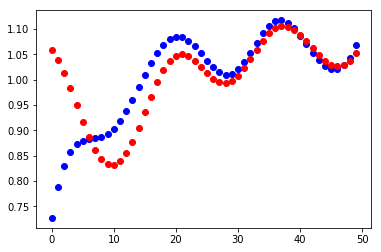

In [26]:
# Plot test example 1
plt.plot(f_test[0, :50], 'bo')
plt.plot(pred_f_left_test[0], 'ro')
plt.show()

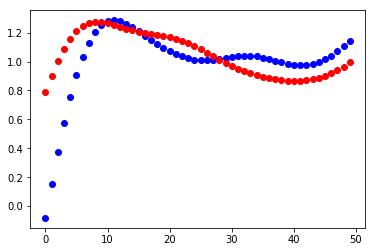

In [27]:
# Plot test example 2
plt.plot(f_test[5, :50], 'bo')
plt.plot(pred_f_left_test[5], 'ro')
plt.show()